### Đọc data từ CSV

In [1]:
import pandas as pd
df = pd.read_csv("./2019-Oct.csv")

In [2]:
df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [3]:
purchase_df = df[df['event_type'] == 'purchase']

In [4]:
purchase_df.count()

event_time       742849
event_type       742849
product_id       742849
category_id      742849
category_code    569424
brand            684544
price            742849
user_id          742849
user_session     742849
dtype: int64

In [5]:
purchase_df = purchase_df.fillna("unknown")

In [6]:
# DataFrame after replacing null values
purchase_df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
162,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
308,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
379,2019-10-01 00:06:02 UTC,purchase,5100816,2053013553375346967,unknown,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56
442,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
574,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553


In [ ]:
# import pyarrow.parquet as pq
# import pyarrow as pa
# import pandas as pd
# import glob

# path = "./data/*.parquet"
# files = sorted(glob.glob(path))
# print("Found files:", len(files))

# # accumulate filtered frames
# purchase_frames = []
# for i, f in enumerate(files):
#     print(f"Reading {i+1}/{len(files)}: {f}")
#     tmp = pq.read_table(f) 
#     df = tmp.to_pandas(ignore_metadata=True)       

#     df = df[df['event_type'] == 'purchase'].copy()

#     purchase_frames.append(df)
    
# purchase_df = pd.concat(purchase_frames, ignore_index=True)
# print("Total purchase rows:", purchase_df.shape[0])
# del purchase_frames

### Chuẩn hóa nhanh & lọc session có >= 2 sản phẩm

In [ ]:
purchase_df['event_time'] = pd.to_datetime(purchase_df['event_time'])
purchase_df['product_id'] = purchase_df['product_id'].astype(str)  # cho mlxtend

# Lọc session có >=2 sản phẩm
session_counts = purchase_df.groupby("user_session")["product_id"].nunique()
valid_sessions = session_counts[session_counts > 1].index
purchase_df = purchase_df[purchase_df['user_session'].isin(valid_sessions)].copy()
print("After session>=2 filter:", purchase_df.shape)

After session>=2 filter: (121990, 9)


### Tạo sample 

In [ ]:
N_SESSIONS = 60000   # thay nếu RAM ít/ nhiều
unique_sessions = purchase_df['user_session'].unique()
sample_sessions = unique_sessions[:N_SESSIONS]
sample_df = purchase_df[purchase_df['user_session'].isin(sample_sessions)].copy()
print("Sample rows:", sample_df.shape)

Sample rows: (121990, 9)


In [14]:
### Giới hạn số sản phẩm (giảm chiều): chọn top K sản phẩm bán chạy nhất:
TOP_K = 500   # thử 300-500
top_brands = sample_df['brand'].value_counts().head(TOP_K).index
filtered_df = sample_df[sample_df['brand'].isin(top_brands)].copy()

### Ma trận Brands Transaction

In [15]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

df_for_fpgrowth = filtered_df  # hoặc sample_df nếu không lọc top K

basket = (df_for_fpgrowth
          .groupby(['user_session', 'brand'])['event_type']
          .count()
          .unstack(fill_value=0))

basket = (basket > 0).astype(bool)
print("Basket shape:", basket.shape)

MIN_SUPPORT = 0.001  # điều chỉnh: 0.001, 0.003,...
freq_itemsets = fpgrowth(basket, min_support=MIN_SUPPORT, use_colnames=True)
print("Frequent itemsets:", freq_itemsets.shape[0])

rules = association_rules(freq_itemsets, metric="lift", min_threshold=1.2)
rules = rules.sort_values('confidence', ascending=False).reset_index(drop=True)
print("Rules:", len(rules))
display(rules.head(10))

Basket shape: (48172, 500)
Frequent itemsets: 210
Rules: 42


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(bts),(unknown),0.002719,0.158827,0.001308,0.480916,3.027929,1.0,0.000876,1.620496,0.671568,0.008162,0.382905,0.244575
1,(brw),(unknown),0.002595,0.158827,0.001225,0.472000,2.971792,1.0,0.000813,1.593131,0.665229,0.007645,0.372305,0.239856
2,(sv),(unknown),0.003571,0.158827,0.001495,0.418605,2.635606,1.0,0.000928,1.446818,0.622804,0.009289,0.308828,0.214008
3,(lucente),(unknown),0.041414,0.158827,0.017002,0.410526,2.584744,1.0,0.010424,1.426990,0.639603,0.092784,0.299224,0.258786
4,(sokolov),(unknown),0.004899,0.158827,0.001765,0.360169,2.267689,1.0,0.000986,1.314681,0.561775,0.010895,0.239359,0.185640
5,(asus),(acer),0.004941,0.019555,0.001329,0.268908,13.751396,1.0,0.001232,1.341069,0.931884,0.057348,0.254326,0.168424
6,(sokolov),(lucente),0.004899,0.041414,0.001225,0.250000,6.036591,1.0,0.001022,1.278115,0.838451,0.027164,0.217598,0.139787
7,(respect),(unknown),0.004878,0.158827,0.001163,0.238298,1.500364,1.0,0.000388,1.104334,0.335130,0.007152,0.094477,0.122809
8,(meizu),(xiaomi),0.004816,0.098148,0.001100,0.228448,2.327583,1.0,0.000628,1.168880,0.573130,0.010801,0.144480,0.119829
9,(stels),(unknown),0.006331,0.158827,0.001391,0.219672,1.383093,1.0,0.000385,1.077974,0.278748,0.008493,0.072334,0.114215


### Tạo dictionary 

In [16]:
from collections import defaultdict
ante_to_cons = defaultdict(set)
for _, r in rules.iterrows():
    ants = tuple(sorted(list(r['antecedents'])))
    cons = tuple(sorted(list(r['consequents'])))
    ante_to_cons[ants].update(cons)

def get_candidates_from_rules(user_items):
    user_items = set(user_items)
    cands = set()
    for ants, cons in ante_to_cons.items():
        if set(ants).issubset(user_items):
            cands.update(cons)
    return list(cands)


### Training

In [18]:
# brand stats
brand_pop = purchase_df['brand'].value_counts().to_dict()
brand_price = purchase_df.groupby('brand')['price'].mean().to_dict()

# user RFM (dùng toàn purchase_df)
snapshot_date = purchase_df['event_time'].max() + pd.Timedelta(days=1)
rfm = purchase_df.groupby('user_id').agg({
    'event_time': lambda x: (snapshot_date - x.max()).days,
    'user_session': 'nunique',
    'price': 'sum'
}).rename(columns={'event_time':'Recency','user_session':'Frequency','price':'Monetary'}).fillna(0)


In [19]:
import numpy as np

rows = []
MAX_SESSIONS_FOR_TRAIN = 20000  
train_sessions = df_for_fpgrowth['user_session'].unique()[:MAX_SESSIONS_FOR_TRAIN]

for sid in train_sessions:
    grp = df_for_fpgrowth[df_for_fpgrowth['user_session']==sid]
    user = grp['user_id'].iloc[0]
    user_items = set(grp['brand'].unique())

    # candidates từ rules
    candidates = get_candidates_from_rules(user_items)

    # positives
    for p in user_items:
        rows.append({'user_session':sid,'user_id':user,'brand':p,'label':1,
                     'pop': brand_pop.get(p,0),'price':brand_price.get(p,np.nan),
                     'user_recency': rfm.loc[user,'Recency'] if user in rfm.index else np.nan,
                     'user_freq': rfm.loc[user,'Frequency'] if user in rfm.index else np.nan})
        
    # negatives: sample <=3 negatives from candidates not in user_items
    negs = [c for c in candidates if c not in user_items]
    if len(negs)>0:
        neg_sample = np.random.choice(negs, size=min(3,len(negs)), replace=False)
        for p in neg_sample:
            rows.append({'user_session':sid,'user_id':user,'brand':p,'label':0,
                         'pop': brand_pop.get(p,0),'price':brand_price.get(p,np.nan),
                         'user_recency': rfm.loc[user,'Recency'] if user in rfm.index else np.nan,
                         'user_freq': rfm.loc[user,'Frequency'] if user in rfm.index else np.nan})

train_df = pd.DataFrame(rows).fillna(0)
print("Train rows:", train_df.shape)
train_df.head()

Train rows: (56023, 8)


,user_session,user_id,brand,label,pop,price,user_recency,user_freq
0,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,551377651,apple,1,25354,792.437286,7,5
1,7954f58c-158d-402d-9820-c502a5eea86d,517953667,unknown,1,11327,149.057081,3,6
2,7954f58c-158d-402d-9820-c502a5eea86d,517953667,lucente,0,2835,267.660825,3,6
3,7954f58c-158d-402d-9820-c502a5eea86d,517953667,sokolov,0,308,150.745617,3,6
4,7954f58c-158d-402d-9820-c502a5eea86d,517953667,sv,0,205,260.371951,3,6


In [20]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

features = ['pop','price','user_recency','user_freq']
X = train_df[features]
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

params = {'objective':'binary','metric':'auc','verbosity':-1,'boosting_type':'gbdt','seed':42}
model = lgb.train(
    params,
    dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dval],
    valid_names=["train", "val"],
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

pred = model.predict(X_val)
print("AUC:", roc_auc_score(y_val, pred))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[109]	train's auc: 0.949372	val's auc: 0.942142
AUC: 0.9421422805878883


### Recommend

In [ ]:
def recommend_for_user(user_id, topk=10):
    user_sessions = purchase_df[purchase_df['user_id']==user_id].sort_values('event_time', ascending=False)
    if user_sessions.empty: return []
    last_sid = user_sessions['user_session'].iloc[0]
    user_items = set(purchase_df[purchase_df['user_session']==last_sid]['brand'].unique())
    cands = get_candidates_from_rules(user_items)
    cands = [c for c in cands if c not in user_items]
    if not cands: return []
    rows = []
    for p in cands:
        rows.append({'brand':p,'pop':brand_pop.get(p,0),'price':brand_price.get(p,0),
                     'user_recency': rfm.loc[user_id,'Recency'] if user_id in rfm.index else 999,
                     'user_freq': rfm.loc[user_id,'Frequency'] if user_id in rfm.index else 0})
    Xcand = pd.DataFrame(rows)[features]
    scores = model.predict(Xcand)
    res = pd.DataFrame(rows)
    res['score'] = scores
    return res.sort_values('score', ascending=False).head(topk)['brand'].tolist()

In [24]:
# Print out recommendation for an user
recommendations = recommend_for_user(user_id=555332717, topk=10)
print(recommendations)

['lucente', 'stels', 'sokolov', 'respect', 'bts', 'brw', 'sv']


### Visualize

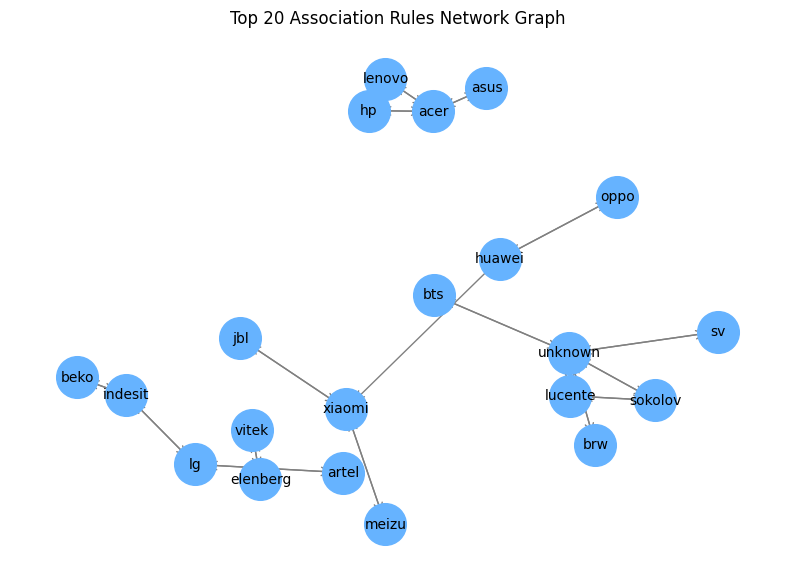

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# === LẤY 20 LUẬT MẠNH NHẤT ===
top_rules = rules.nlargest(35, 'lift')

# === TẠO GRAPH ===
G = nx.DiGraph()

for _, r in top_rules.iterrows():
    a = list(r['antecedents'])[0]
    c = list(r['consequents'])[0]
    G.add_edge(a, c, weight=r['lift'], conf=r['confidence'])

# === VẼ GRAPH ===
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.9, seed=42)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=900, node_color="#66b3ff")

# edges
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color="gray")

# labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Top 20 Association Rules Network Graph")
plt.axis("off")
plt.show()


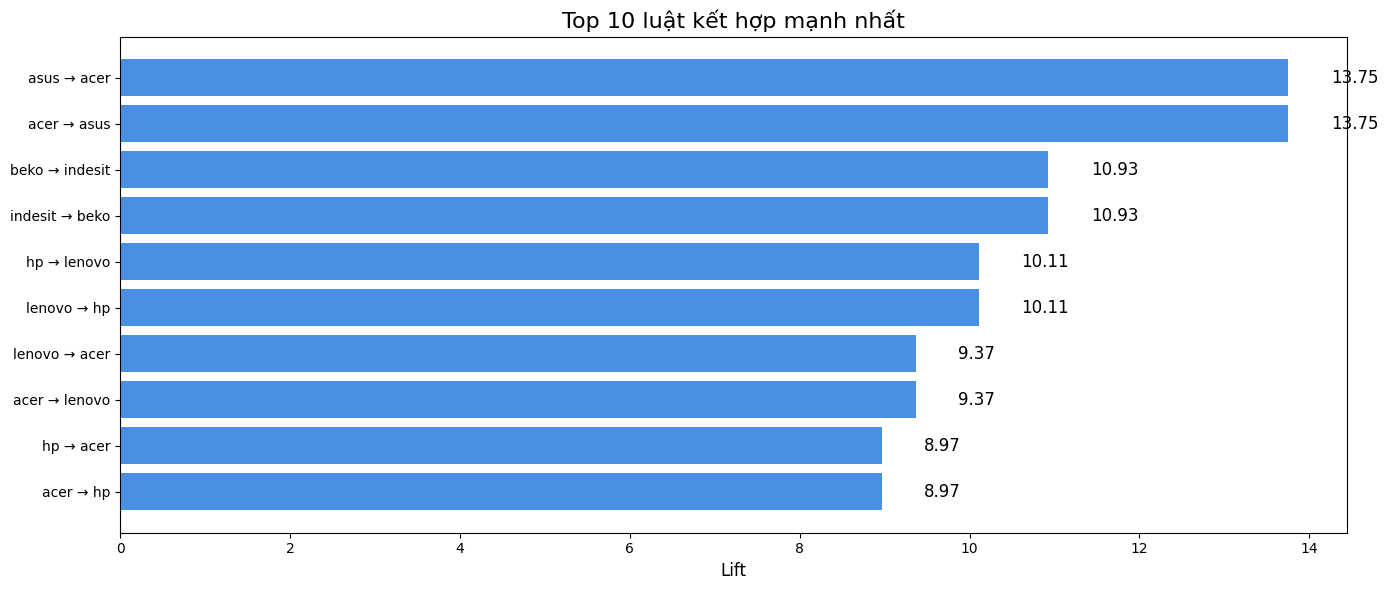

In [27]:
import matplotlib.pyplot as plt

# Lấy top 10 luật lift cao nhất
top10 = rules.nlargest(10, 'lift').copy()

# Hàm chuyển frozenset thành chuỗi "A, B, C"
def fs_to_str(fs):
    return ", ".join(list(fs))

# Tạo label dạng "A → B"
top10['label'] = top10.apply(
    lambda row: f"{fs_to_str(row['antecedents'])} → {fs_to_str(row['consequents'])}",
    axis=1
)

plt.figure(figsize=(14, 6))

plt.barh(top10['label'], top10['lift'], color="#4A90E2")

plt.xlabel("Lift", fontsize=12)
plt.title("Top 10 luật kết hợp mạnh nhất", fontsize=16)
plt.gca().invert_yaxis()  # để luật mạnh nhất nằm trên đầu

# Giá trị số trên từng thanh
for index, value in enumerate(top10['lift']):
    plt.text(value + 0.5, index, f"{value:.2f}", va='center', fontsize=12)

plt.tight_layout()
plt.show()


In [28]:
# === LẤY TOP 20 LUẬT ===
top_rules = rules.nlargest(20, 'lift')

items = sorted(list(
    set([list(a)[0] for a in top_rules['antecedents']]) |
    set([list(c)[0] for c in top_rules['consequents']])
))

# === TẠO MA TRẬN LIFT ===
lift_matrix = pd.DataFrame(0.0, index=items, columns=items, dtype=float)

for _, r in top_rules.iterrows():
    a = list(r['antecedents'])[0]
    c = list(r['consequents'])[0]
    lift_matrix.loc[a, c] = r['lift']

# === RÚT GỌN LABEL: CHỈ LẤY 4 SỐ CUỐI ===
short_rows = [str(i)[-4:] for i in lift_matrix.index]
short_cols = [str(i)[-4:] for i in lift_matrix.columns]

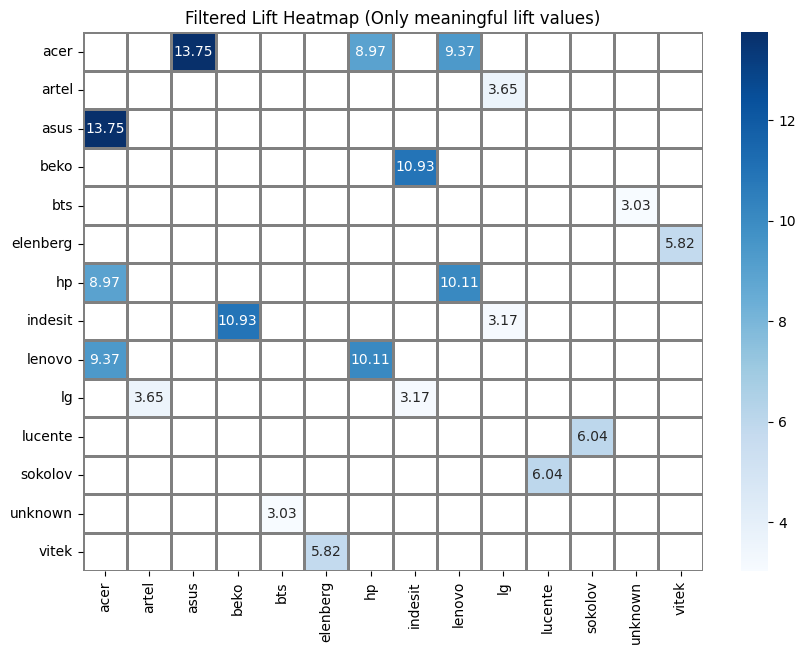

In [29]:
# bỏ ô 0.00
mask = (lift_matrix == 0)

plt.figure(figsize=(10, 7))
sns.heatmap(
    lift_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    mask=mask,               # ẨN Ô 0
    linewidths=1,
    linecolor='gray'
)
plt.title("Filtered Lift Heatmap (Only meaningful lift values)")
plt.show()


### Phân tích hành vi Click 

### Tỷ lệ khách click nhưng không mua

In [31]:
views  = df[df['event_type'] == 'view']['brand'].nunique()
carts  = df[df['event_type'] == 'cart']['brand'].nunique()
buys   = df[df['event_type'] == 'purchase']['brand'].nunique()

print("View → Cart:", carts / views)
print("Cart → Purchase:", buys / carts)
print("View → Purchase:", buys / views)

View → Cart: 0.16898954703832753
Cart → Purchase: 3.4072164948453607
View → Purchase: 0.5757839721254355


### TOP sản phẩm được CLICK nhiều nhất

In [33]:
top_click = df[df['event_type']=="view"]['brand'].value_counts().head(20)
top_click

brand
samsung     4806630
apple       3770597
xiaomi      2922650
huawei      1045572
lucente      644283
bosch        544230
lg           540131
oppo         451449
sony         439855
acer         411871
cordiant     351996
lenovo       330608
artel        325650
hp           298907
dauscher     284311
indesit      278172
philips      271734
redmond      269944
respect      269310
casio        255237
Name: count, dtype: int64

<Axes: title={'center': 'Top sản phẩm được click nhiều nhất'}, xlabel='brand'>

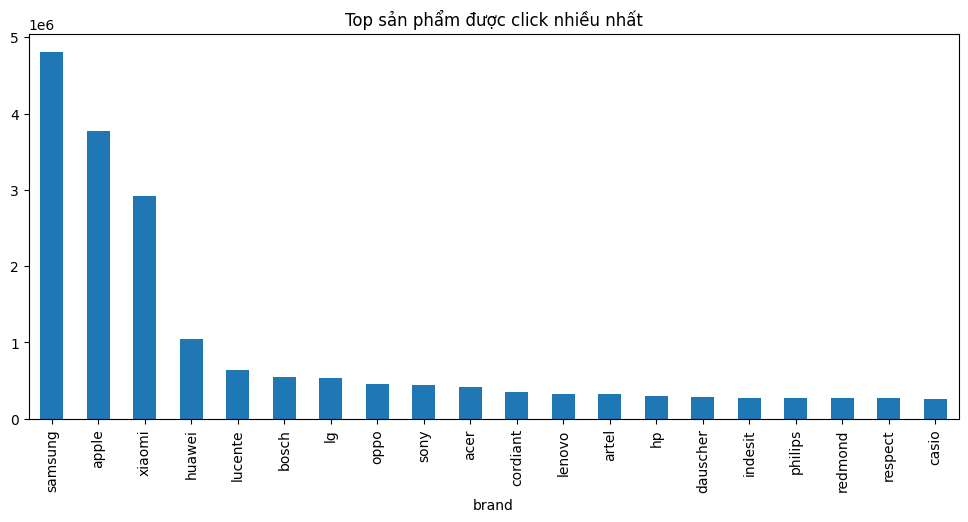

In [34]:
top_click.plot(kind='bar', figsize=(12,5), title="Top sản phẩm được click nhiều nhất")


### Phân tích mức độ hấp dẫn của từng sản phẩm.

In [35]:
views = df[df['event_type']=="view"].groupby("brand").size()
buys  = df[df['event_type']=="purchase"].groupby("brand").size()

conversion = (buys / views).fillna(0).sort_values(ascending=False)
conversion.head(20)

brand
dotemu        0.500000
zhejiang      0.250000
kleancolor    0.142857
casela        0.142857
plamers       0.125000
bouncin       0.111111
neptun        0.111111
doona         0.100000
crusader      0.090909
alumet        0.090909
faans         0.090909
rimmel        0.090909
unikum        0.083333
oribel        0.083333
orium         0.083146
neoclassic    0.076923
chaod         0.076923
vionne        0.076923
atlas         0.076923
jinyu         0.075342
dtype: float64

<Axes: title={'center': 'Top 20 Conversion Rates'}, ylabel='brand'>

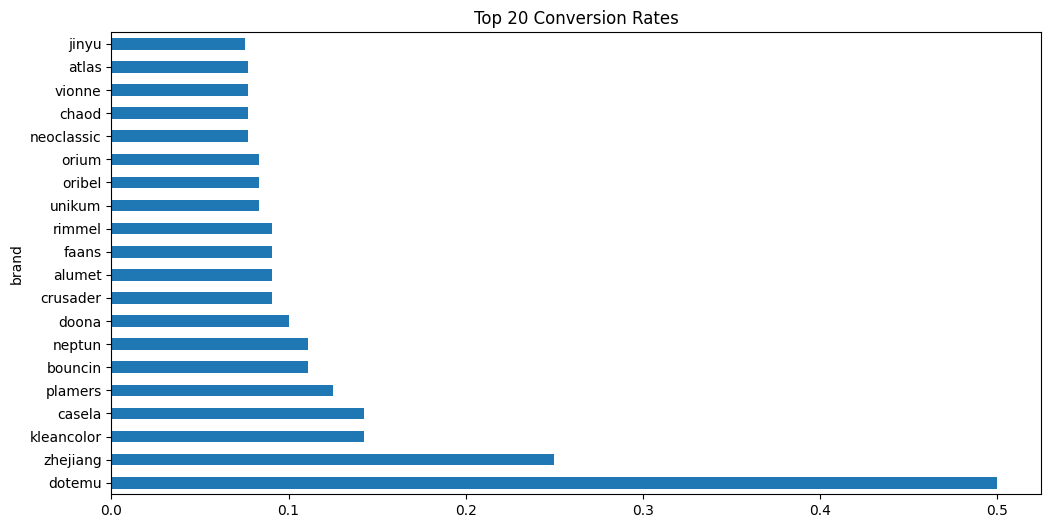

In [36]:
conversion.head(20).plot(kind="barh", figsize=(12,6), title="Top 20 Conversion Rates")

### Phân tích chuỗi hành vi trong session

In [46]:
click_df = df[df['event_type']=="view"]
click_df = click_df.sort_values(["user_session", "event_time"])

click_df["next_click"] = click_df.groupby("user_session")["brand"].shift(-1)

pairs = click_df.dropna()[["brand", "next_click"]]
pairs = pairs.value_counts().head(10)
pairs

brand    next_click
samsung  samsung       2696745
apple    apple         2177410
xiaomi   xiaomi        1601307
huawei   huawei         580801
lg       lg             252108
oppo     oppo           248258
acer     acer           211170
lenovo   lenovo         169930
bosch    bosch          160428
casio    casio          150509
Name: count, dtype: int64

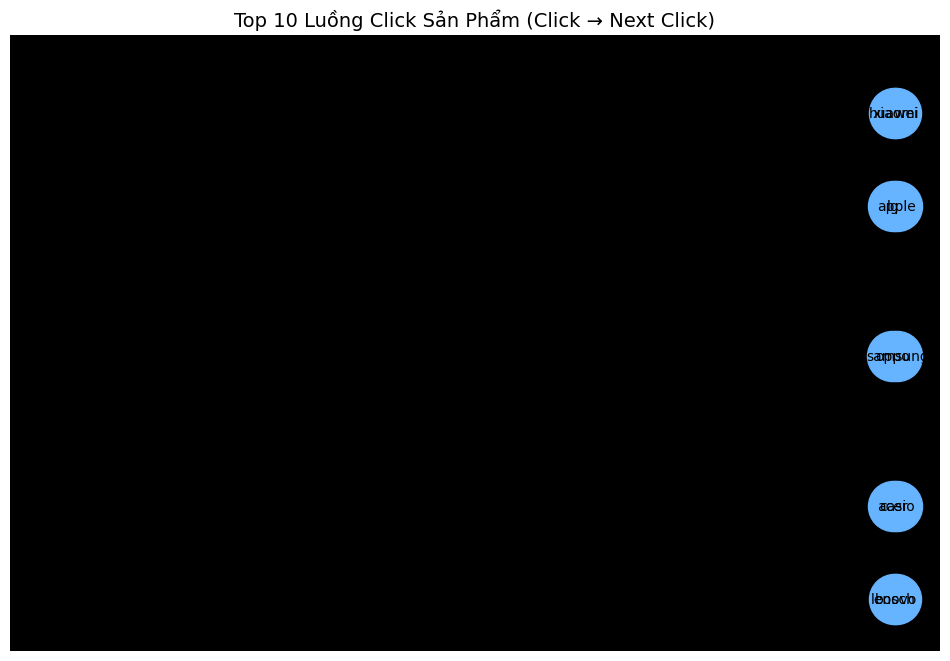

In [47]:
import networkx as nx
import matplotlib.pyplot as plt

# Tạo graph có hướng
G = nx.DiGraph()

# Thêm edge với trọng số
for (a, b), count in pairs.items():
    G.add_edge(a, b, weight=count)

# Layout đẹp nhất cho kiểu flow
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 8))

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=1300, node_color="#66b3ff")

# Edges
nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->", arrowsize=20,
    width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()]  # độ dày theo số lần click
)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Top 10 Luồng Click Sản Phẩm (Click → Next Click)", fontsize=14)
plt.axis("off")
plt.show()


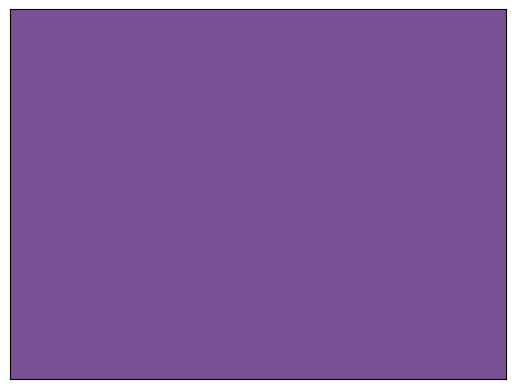

In [48]:
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_w = max(weights)

colors = ["#003f5c" if G[u][v]['weight'] == max_w else "#7a5195" for u,v in G.edges()]

nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->",
    arrowsize=18,
    width=[w*0.1 for w in weights],
    edge_color=colors
)


### phân tích hành vi VIEW-TO-VIEW

In [45]:
# CLICK DATA: Lấy top 200 sản phẩm → không bị MemoryError
view_df = df[df["event_type"]=="view"].copy()
view_df["brand"] = view_df["brand"].astype(str)

top_products = view_df["brand"].value_counts().head(200).index
view_df = view_df[view_df["brand"].isin(top_products)]

# Lọc session có >= 2 click
session_counts = view_df.groupby("user_session")["brand"].nunique()
valid = session_counts[session_counts > 1].index
view_df = view_df[view_df["user_session"].isin(valid)]

# Lấy 20k session
sample_sessions = view_df["user_session"].unique()[:20000]
sample_view = view_df[view_df["user_session"].isin(sample_sessions)]

# Basket
basket = (sample_view
          .groupby(["user_session", "brand"])["event_type"]
          .count().unstack().fillna(0))
basket = (basket > 0).astype(bool)

# FP-Growth
from mlxtend.frequent_patterns import fpgrowth, association_rules

fi = fpgrowth(basket, min_support=0.002, use_colnames=True)
rules_click = association_rules(fi, metric="lift", min_threshold=1.1)

rules_click = rules_click.sort_values("lift", ascending=False)
rules_click.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1515,(starline),(pandora),0.00900,0.00350,0.00265,0.294444,84.126984,1.0,0.002619,1.412362,0.997087,0.269036,0.291966,0.525794
1514,(pandora),(starline),0.00350,0.00900,0.00265,0.757143,84.126984,1.0,0.002619,4.080588,0.991584,0.269036,0.754937,0.525794
1505,(netechnics),(pulser),0.00405,0.00705,0.00205,0.506173,71.797566,1.0,0.002021,2.010724,0.990082,0.226519,0.502667,0.398476
1504,(pulser),(netechnics),0.00705,0.00405,0.00205,0.290780,71.797566,1.0,0.002021,1.404290,0.993073,0.226519,0.287896,0.398476
1838,(neoline),(ibox),0.00525,0.00645,0.00210,0.400000,62.015504,1.0,0.002066,1.655917,0.989068,0.218750,0.396105,0.362791


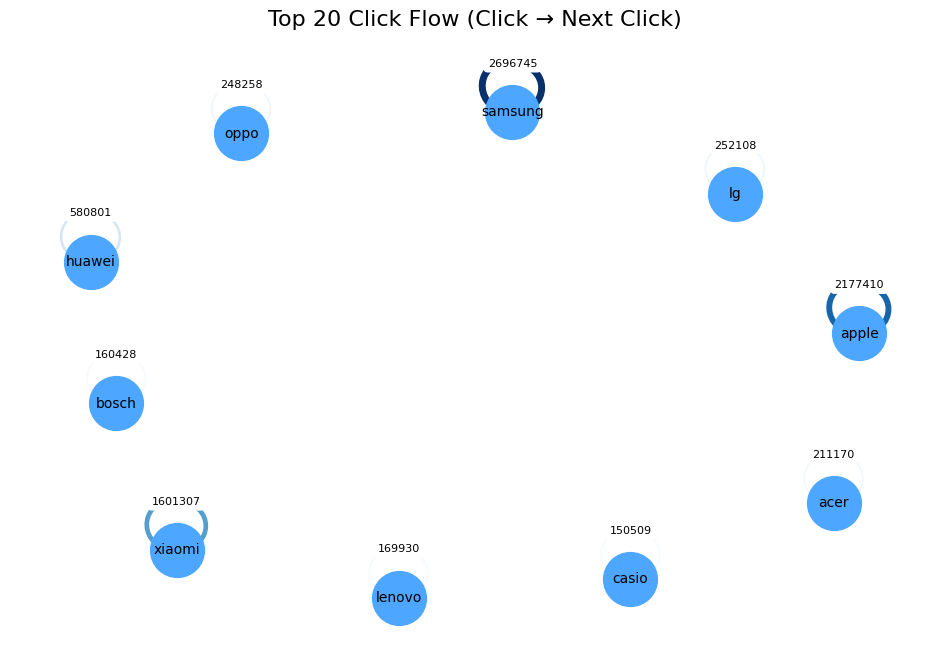

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Tạo graph
G = nx.DiGraph()
for (a, b), w in pairs.items():
    G.add_edge(a, b, weight=w)

# Layout đẹp dạng “flow”
pos = nx.spring_layout(G, k=1.5, seed=42)

plt.figure(figsize=(12, 8))

# Lấy trọng số để tô màu
weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
norm = plt.Normalize(weights.min(), weights.max())
colors = cm.Blues(norm(weights))

# Vẽ node
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="#4DA6FF")

# Vẽ edge có MÀU + ĐỘ DÀY + MŨI TÊN
nx.draw_networkx_edges(
    G, pos,
    arrowstyle="->", arrowsize=18,
    width=weights / weights.max() * 4 + 1,
    edge_color=colors
)

# Node label
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge label (số lần click)
edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Top 20 Click Flow (Click → Next Click)", fontsize=16)
plt.axis("off")
plt.show()


#### HeatMap click

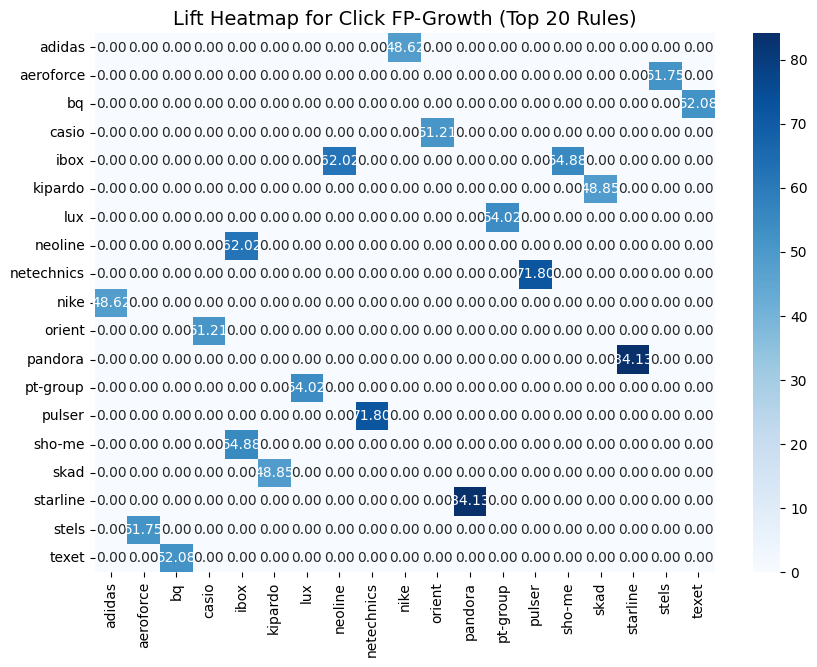

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Lấy top 20 luật click
top_rules = rules_click.head(20)

items = sorted(list(
    set(top_rules['antecedents'].apply(lambda x: list(x)[0])) |
    set(top_rules['consequents'].apply(lambda x: list(x)[0]))
))

# Tạo ma trận lift
lift_matrix = pd.DataFrame(0.0, index=items, columns=items, dtype=float)
for _, r in top_rules.iterrows():
    a = list(r["antecedents"])[0]
    c = list(r["consequents"])[0]
    lift_matrix.loc[a, c] = r["lift"]

plt.figure(figsize=(10, 7))
sns.heatmap(lift_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Lift Heatmap for Click FP-Growth (Top 20 Rules)", fontsize=14)
plt.show()


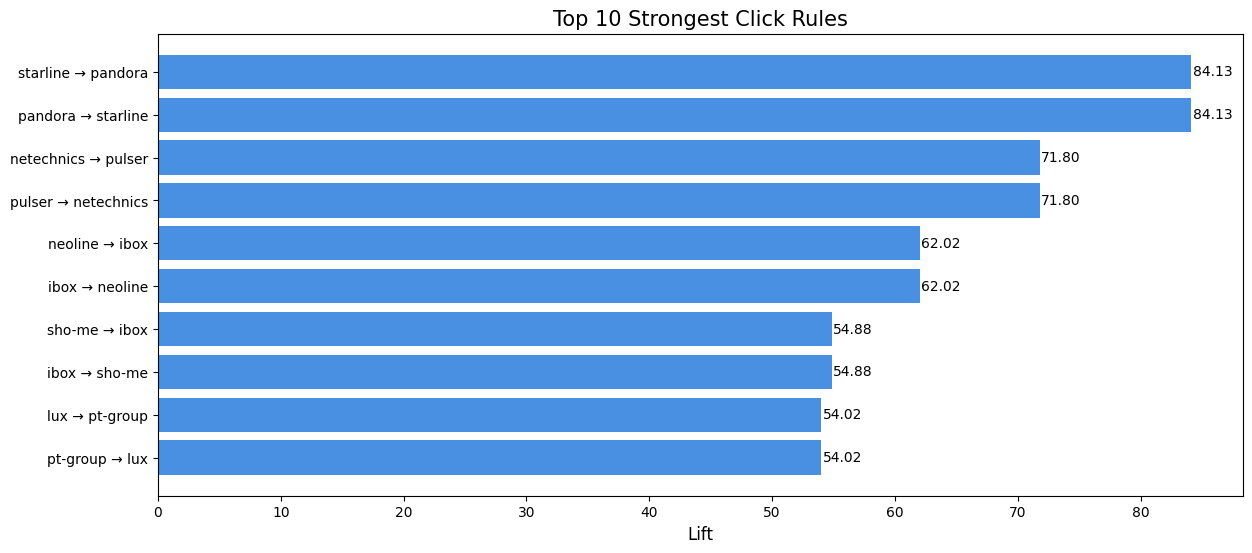

In [51]:
top10 = rules_click.head(10).copy()

# Chuyển frozenset thành string
def fs_to_str(fs):
    return ", ".join(list(fs))

top10["label"] = top10.apply(
    lambda r: f"{fs_to_str(r['antecedents'])} → {fs_to_str(r['consequents'])}",
    axis=1
)

plt.figure(figsize=(14, 6))
plt.barh(top10["label"], top10["lift"], color="#4a90e2")

plt.xlabel("Lift", fontsize=12)
plt.title("Top 10 Strongest Click Rules", fontsize=15)
plt.gca().invert_yaxis()

# hiển thị lift ở cuối từng thanh
for i, v in enumerate(top10["lift"]):
    plt.text(v + 0.1, i, f"{v:.2f}", va='center')

plt.show()


### Phân cụm khách hàng 

### Tạo RFM table

In [52]:
import pandas as pd
import numpy as np

# chỉ lấy purchase
purchase_df = df[df["event_type"] == "purchase"].copy()
purchase_df["event_time"] = pd.to_datetime(purchase_df["event_time"])

# snapshot date = ngày lớn nhất + 1
snapshot_date = purchase_df["event_time"].max() + pd.Timedelta(days=1)

# RFM
rfm = purchase_df.groupby("user_id").agg({
    "event_time": lambda x: (snapshot_date - x.max()).days,   # Recency
    "user_session": "count",                                   # Frequency
    "price": "sum"                                              # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
user_id,,,
264649825,26,2,1240.04
303160429,19,1,340.59
340041246,18,4,915.52
371877401,23,1,29.89
384989212,14,1,41.44


### CHUẨN HÓA & PHÂN CỤM

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

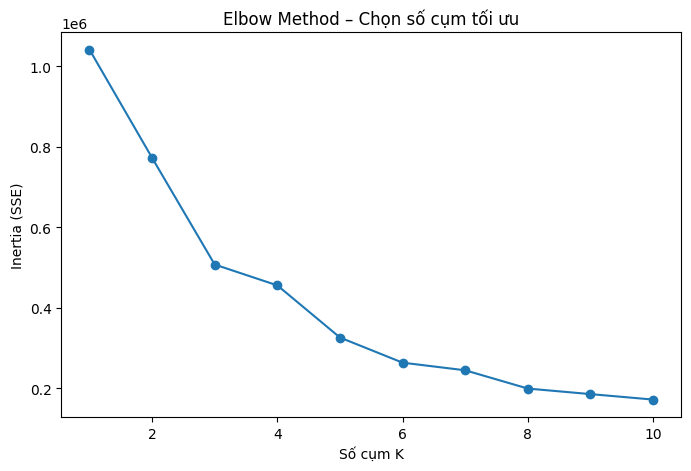

In [54]:
#TÌM SỐ CỤM TỐI ƯU BẰNG ĐỊNH LÝ KHUỶU TAY (Elbow Method)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker="o")
plt.xlabel("Số cụm K")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method – Chọn số cụm tối ưu")
plt.show()


In [55]:
# ÁP DỤNG K-MEANS VỚI SỐ CỤM TỐI ƯU
k_optimal = 4  # thay tùy theo kết quả elbow method

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
rfm["cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,cluster
user_id,,,,
264649825,26,2,1240.04,1
303160429,19,1,340.59,3
340041246,18,4,915.52,3
371877401,23,1,29.89,1
384989212,14,1,41.44,3


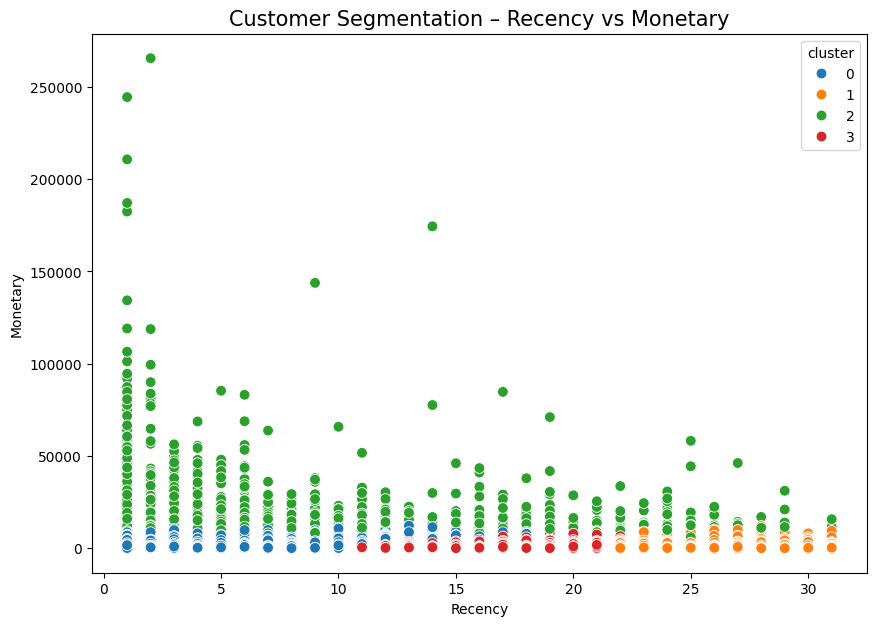

In [56]:
# Recency–Monetary
import seaborn as sns

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="cluster",
    palette="tab10",
    s=60
)
plt.title("Customer Segmentation – Recency vs Monetary", fontsize=15)
plt.show()

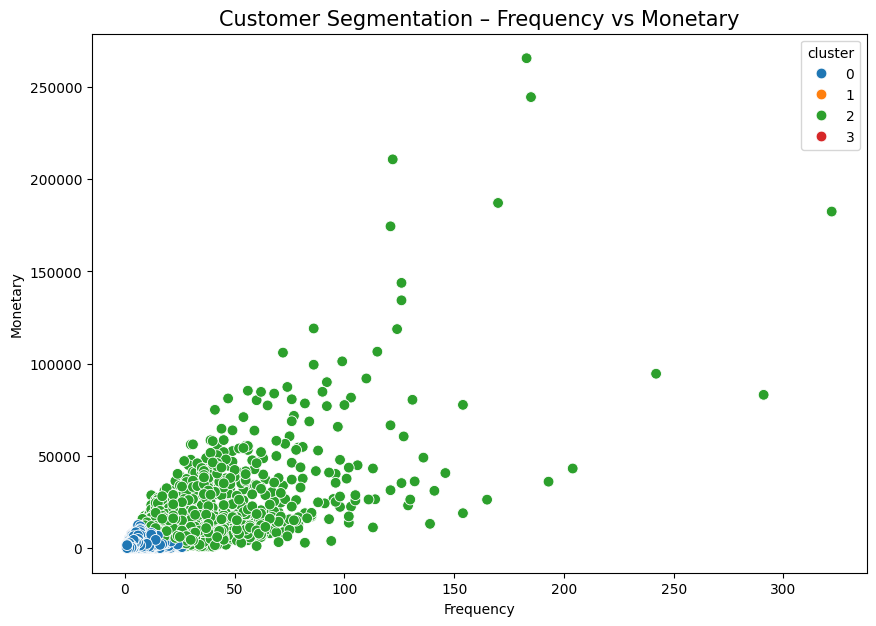

In [57]:
# Frequency–Monetary.
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=rfm,
    x="Frequency",
    y="Monetary",
    hue="cluster",
    palette="tab10",
    s=60
)
plt.title("Customer Segmentation – Frequency vs Monetary", fontsize=15)
plt.show()


### BAR CHART TOP SẢN PHẨM THEO CỤM

Cluster 1


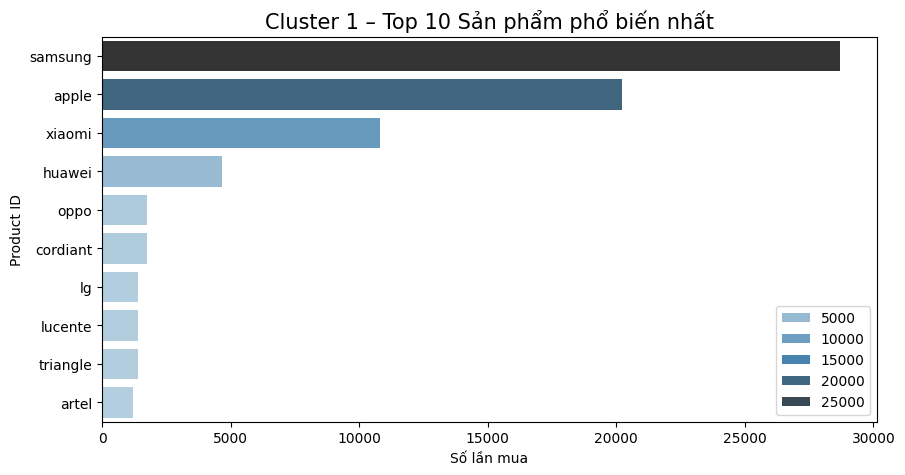

Cluster 3


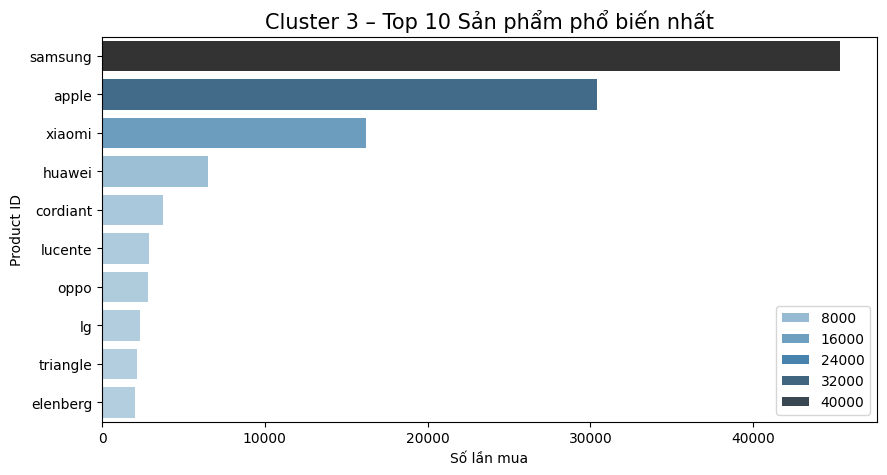

Cluster 0


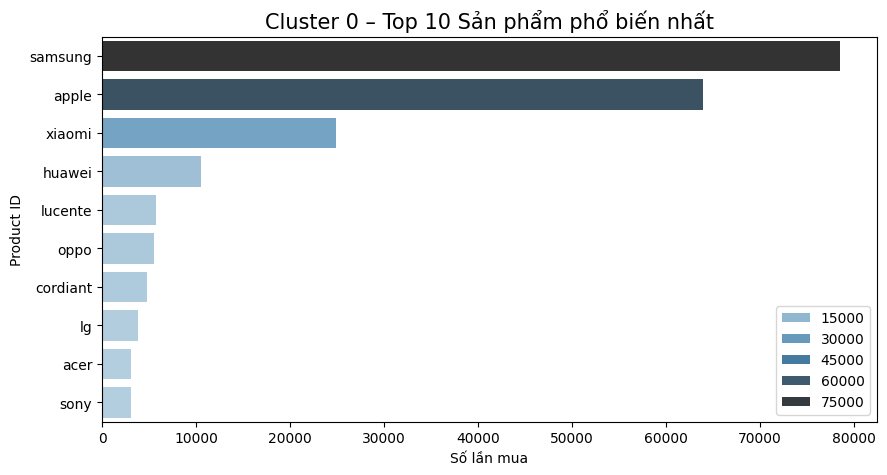

Cluster 2


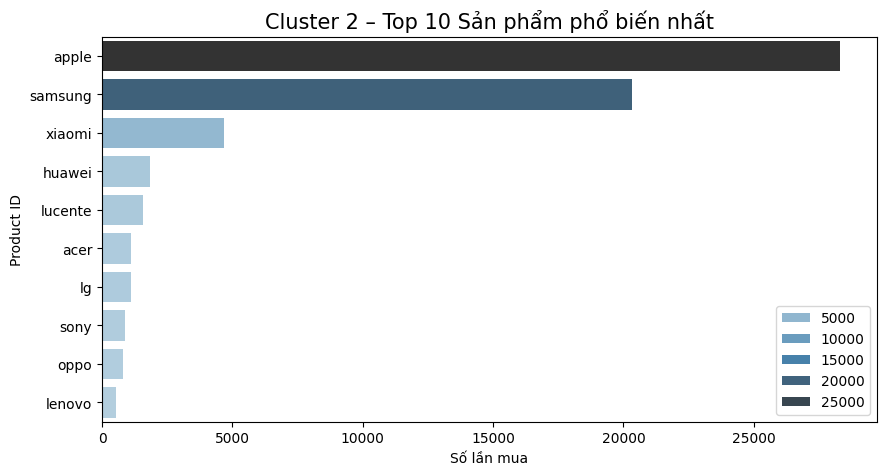

In [58]:
for c in rfm["cluster"].unique():
    print(f"Cluster {c}")
    
    users = rfm[rfm["cluster"] == c].index
    subset = df[(df["user_id"].isin(users)) & (df["event_type"]=="purchase")]

    top_items = subset["brand"].value_counts().head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_items.values, y=top_items.index, palette="Blues_d", hue=top_items.values)
    plt.title(f"Cluster {c} – Top 10 Sản phẩm phổ biến nhất", fontsize=15)
    plt.xlabel("Số lần mua")
    plt.ylabel("Product ID")
    plt.show()


In [59]:
# HEATMAP LUẬT THEO TỪNG CỤM
from mlxtend.frequent_patterns import fpgrowth, association_rules

rules_per_cluster = {}

for c in rfm["cluster"].unique():
    print(f"\nCluster {c}")

    users = rfm[rfm["cluster"] == c].index
    subset = df[(df["user_id"].isin(users)) & (df["event_type"]=="purchase")]

    # Chỉ lấy top 200 sản phẩm trong cluster
    top_products = subset["brand"].value_counts().head(200).index
    subset = subset[subset["brand"].isin(top_products)]

    # Lọc session có >= 2 sp
    session_counts = subset.groupby("user_session")["brand"].nunique()
    valid = session_counts[session_counts > 1].index
    subset = subset[subset["user_session"].isin(valid)]

    # Giới hạn session
    subset = subset[subset["user_session"].isin(subset["user_session"].unique()[:20000])]
    subset["brand"] = subset["brand"].astype(str)

    # Basket
    basket = (subset.groupby(["user_session","brand"])["event_type"]
              .count().unstack().fillna(0))
    basket = (basket > 0).astype(bool)

    fi = fpgrowth(basket, min_support=0.005, use_colnames=True)
    rules = association_rules(fi, metric="lift", min_threshold=1.2)

    rules_per_cluster[c] = rules
    print("Rules:", len(rules))



Cluster 1
Rules: 10

Cluster 3
Rules: 10

Cluster 0
Rules: 2

Cluster 2
Rules: 18


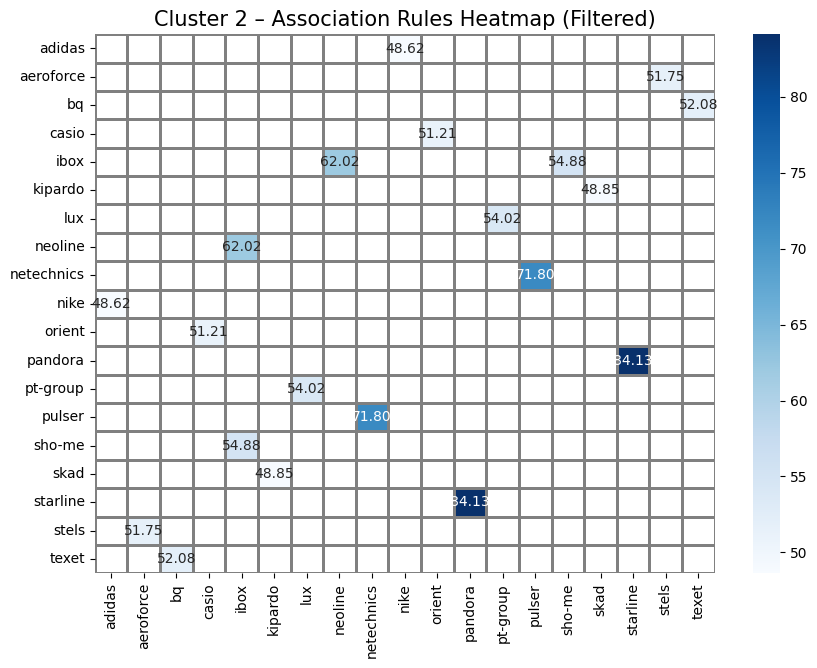

In [60]:
mask = (lift_matrix == 0)

plt.figure(figsize=(10,7))
sns.heatmap(
    lift_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    mask=mask,               # CHE Ô 0
    linewidths=1,
    linecolor="gray",
    cbar=True
)
plt.title(f"Cluster {c} – Association Rules Heatmap (Filtered)", fontsize=15)
plt.show()
